# 2. SORU – İlerletilmiş Kalman Filtresi

İlerletilmiş Kalman Filtresi, normal Kalman filtresinin non-lineer sistemler için özel bir hâlidir. Elimizdeki gürültülü olan verileri kullanarak real-time tahminleme yapar. Apollo 11’in motor iç ısısını ölçmek en bilindik örneklerden birisidir. Motorun içine doğrudan termometre koyamıyoruz, çünkü 5000 F’dan sonar sensör eriyor. Bunun yerine yakıt giriş debimetresi sensörünü ve motorun dış sıcaklığından gelen veriyi kullanarak tahminleme oluşturmuşlar. Sistem gürültülü, çünkü atmosferden dışarı çıktıkça içerdeki sıcaklık ile dışardaki sıcaklık fark gösterebiliyor, yani dış etkene bağlılık söz konusu.

## 2.1. Lidar-and-Radar-sensor-fusion-with-Extended-Kalman-Filter - Matlab

[Sensör Füzyonu](https://www.automotive-iq.com/autonomous-drive/articles/sensor-fusion-technical-challenges-for-level-4-5-self-driving-vehicles), birden çok sensörün bir araya gelip ortaklaşa veri sağladığı sistemdir. Bu projede gnss, imu ve lidar sensörlerinden veri kullanılmıştır. [GitHub](https://github.com/mucahitkayadan/Error-State-Extended-Kalman-Filter)  hesabıma forkladım.
Anaconda – Python 3.6 kullanılarak çalıştırıldı. kullanılarak çalıştırıldı.

## 2.2.	Kodlar ve Açıklamaları

### 2.2.1. Veri

In [3]:
import pickle  #pkl uzantılı dosya oluşturmak ve o dosyayı açmak için eklendi.
import sys      #sistem fonksiyonları kütüphanesi
import numpy as np   #Bilimsel hesaplama yapma, dizi ve matris yönetmek için eklendi.
import matplotlib.pyplot as plt                    #Çizim yapmak için kullanacağımız kütüphane
from mpl_toolkits.mplot3d import Axes3D          #3D çizim yapabilmemizi sağlar.


In [4]:
from rotations import Quaternion, skew_symmetric
# rotations.py dosyasından sınıfları çeker.

In [5]:
sys.path.append('./data')
# verilerin olduğu /data dosyasını dizine ekler.

In [6]:
with open('data/p1_data.pkl', 'rb') as file:
    data = pickle.load(file)
#p1_data.pkl dosyasını çağırıp data adlı değişkene atar.


In [12]:
gt = data['gt']         #ground truth verilerini atar.
imu_f = data['imu_f']   #Special Force olarak Inertial Measurement Unit verilerini atar.
imu_w = data['imu_w']   #Açısal hız olarak Inertial Measurement Unit verilerini atar.
gnss = data['gnss']     #Global Navigation Satellite System verilerini atar.
lidar = data['lidar']   #Lidar verilerini atar.

Aşağıdaki blok, 3D olarak ground truth veriyi çizer.

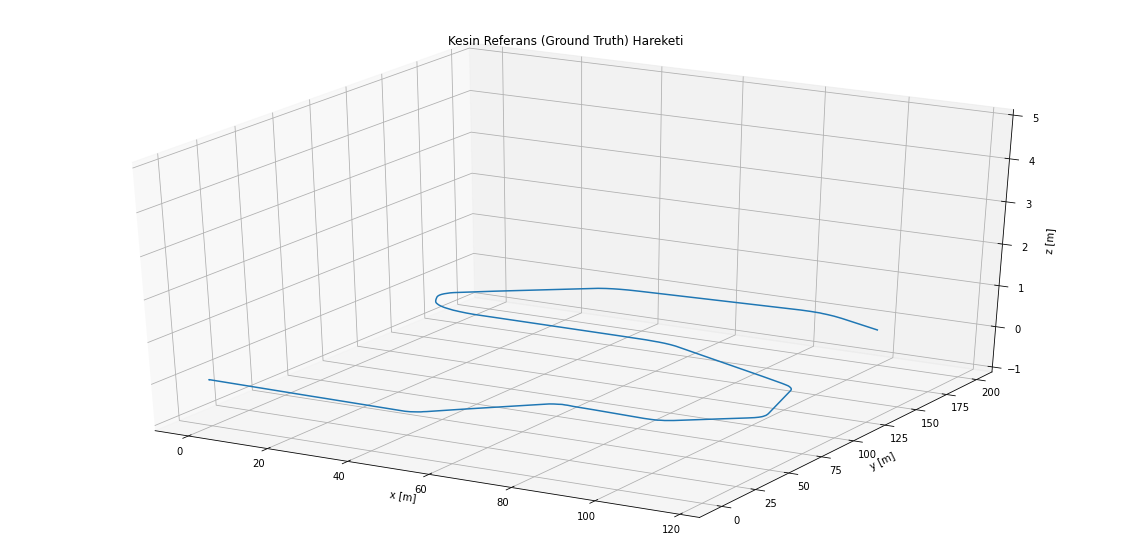

In [35]:
gt_fig = plt.figure(figsize=(20,10))
ax = gt_fig.add_subplot(111, projection='3d')
ax.plot(gt.p[:,0], gt.p[:,1], gt.p[:,2])
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.set_title('Kesin Referans (Ground Truth) Hareketi')
ax.set_zlim(-1, 5)
plt.show()

Lidar verilerini IMU verileri ile örtüştürmek için harici kalibrasyon rotasyon matrisi ve çeviri matrisi kullanıyoruz.

In [14]:
C_li = np.array([
    [ 0.99376, -0.09722,  0.05466],
    [ 0.09971,  0.99401, -0.04475],        #3D rotasyon matrisi
    [-0.04998,  0.04992,  0.9975 ]
])

t_li_i = np.array([0.5, 0.1, 0.5])      # Çeviri matrisi

lidar.data = (C_li @ lidar.data.T).T + t_li_i # @ matris çarpımıdır. .T ise transpozunu verir.

### 2.2.2. Sabitler 

In [15]:
var_imu_f = 0.01
var_imu_w = 0.01
var_gnss = 0.1
var_lidar = 35
gravity = 9.81

In [16]:
g = np.array([0, 0, -gravity])  # gravity
l_jac = np.zeros([9, 6])
l_jac[3:, :] = np.eye(6)  # Hareket modeline Jacobian gürültü ekler. eye fonksiyonu, 
#diagonalı birlerden ve geri kalanı sıfırlardan oluşan matris oluşturur.
h_jac = np.zeros([3, 9])
h_jac[:, :3] = np.eye(3)  # measurement model jacobian

### 2.2.3. Başlangıç Değerleri 

In [17]:
p_est = np.zeros([imu_f.data.shape[0], 3])  # Pozisyon tahmini
v_est = np.zeros([imu_f.data.shape[0], 3])  # Hız tahmini
q_est = np.zeros([imu_f.data.shape[0], 4])  # Kuaterniyon(Euler şeklinde, imajiner) olarak dönüş tahmini
p_cov = np.zeros([imu_f.data.shape[0], 9, 9])  # covariance matrices at each timestep

In [18]:
p_est[0] = gt.p[0]
v_est[0] = gt.v[0]
q_est[0] = Quaternion(euler=gt.r[0]).to_numpy()
p_cov[0] = np.eye(9)  # Tahminin kovaryansı

In [19]:
def measurement_update(sensor_var, p_cov_check, y_k, p_check, v_check, q_check):
    # 3.1 Compute Kalman Gain
    R_cov = sensor_var * np.eye(3)
    K = p_cov_check.dot(h_jac.T.dot(np.linalg.inv(h_jac.dot(p_cov_check.dot(h_jac.T)) + R_cov)))

    # 3.2 Compute error state
    delta_x = K.dot(y_k - p_check)

    # 3.3 Correct predicted state
    p_check = p_check + delta_x[:3]
    v_check = v_check + delta_x[3:6]
    q_check = Quaternion(axis_angle = delta_x[6:]).quat_mult(q_check)

    # 3.4 Compute corrected covariance
    p_cov_check = (np.eye(9) - K.dot(h_jac)).dot(p_cov_check)

    return p_check, v_check, q_check, p_cov_check


### 2.2.4. Ana Döngü 

In [20]:
for k in range(1, imu_f.data.shape[0]):  # start at 1 b/c we have initial prediction from gt
    delta_t = imu_f.t[k] - imu_f.t[k - 1]

    # 1. Update nominal state with IMU inputs
    Rotation_Mat = Quaternion(*q_est[k - 1]).to_mat()
    p_est[k] = p_est[k - 1] + delta_t * v_est[k - 1] + 0.5 * (delta_t ** 2) * (Rotation_Mat.dot(imu_f.data[k - 1]) + g)
    v_est[k] = v_est[k - 1] + delta_t * (Rotation_Mat.dot(imu_f.data[k - 1]) - g)
    q_est[k] = Quaternion(euler = delta_t * imu_w.data[k - 1]).quat_mult(q_est[k - 1])

    # 1.1 Linearize Motion Model and compute Jacobians
    F = np.eye(9)
    imu = imu_f.data[k - 1].reshape((3, 1))
    F[0:3, 3:6] = delta_t * np.eye(3)
    F[3:6, 6:9] = Rotation_Mat.dot(-skew_symmetric(imu)) * delta_t

    # 2. Propagate uncertainty
    Q = np.eye(6)
    Q[0:3, 0:3] = var_imu_f * Q[0:3, 0:3]
    Q[3:6, 3:6] = var_imu_w * Q[3:6, 3:6]
    Q = (delta_t ** 2) * Q #Integration acceleration to obstain Position
    p_cov[k] = F.dot(p_cov[k - 1]).dot(F.T) + l_jac.dot(Q).dot(l_jac.T)

    # 3. Check availability of GNSS and LIDAR measurements
    for i in range(len(gnss.t)):
        if abs(gnss.t[i] - imu_f.t[k]) < 0.01:
            p_est[k], v_est[k], q_est[k], p_cov[k] = measurement_update(var_gnss, p_cov[k],
                                                    gnss.data[i], p_est[k], v_est[k], q_est[k])
    for i in range(len(lidar.t)):
        if abs(lidar.t[i] - imu_f.t[k]) < 0.01:
            p_est[k], v_est[k], q_est[k], p_cov[k] = measurement_update(var_lidar, p_cov[k],
                                                    lidar.data[i], p_est[k], v_est[k], q_est[k])

### 2.2.5.Sonuç ve Analiz

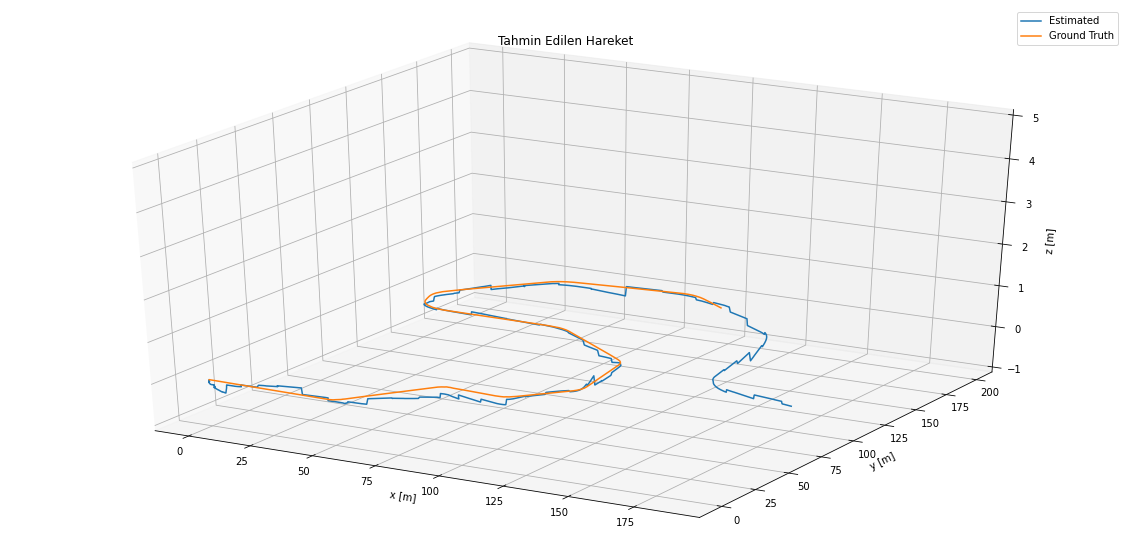

In [28]:
est_traj_fig = plt.figure(figsize=(20,10))
ax = est_traj_fig.add_subplot(111, projection='3d')
ax.plot(p_est[:,0], p_est[:,1], p_est[:,2], label='Estimated')
ax.plot(gt.p[:,0], gt.p[:,1], gt.p[:,2], label='Ground Truth')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.set_title('Tahmin Edilen Hareket')
ax.legend()
ax.set_zlim(-1, 5)
plt.show()

<Figure size 1440x720 with 0 Axes>

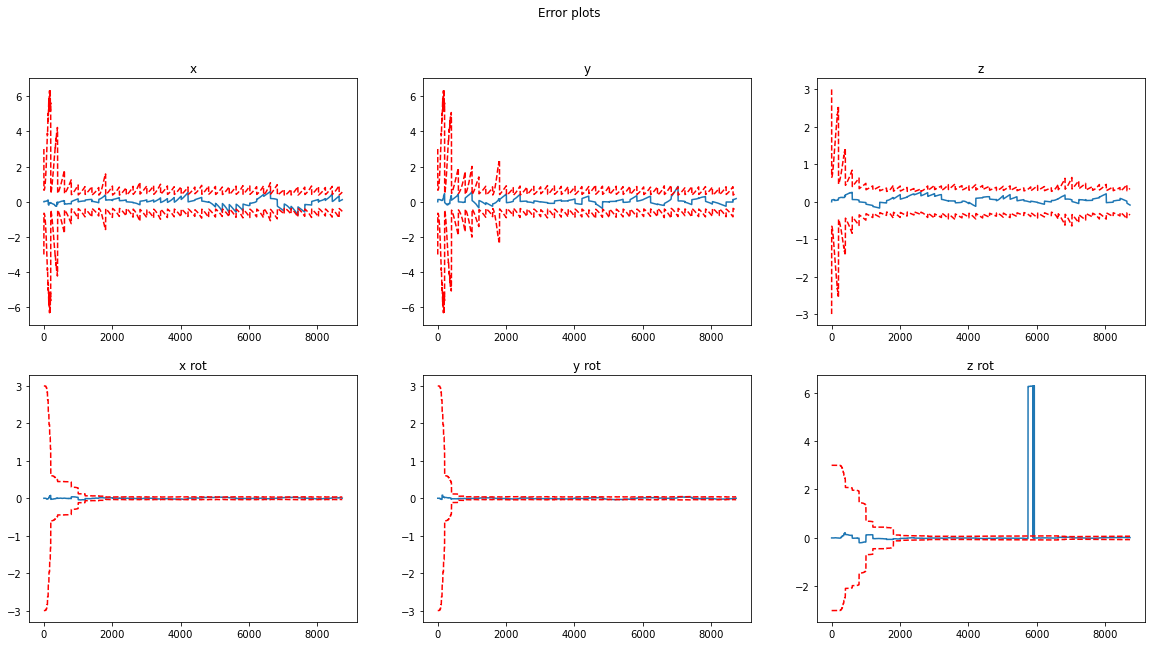

In [42]:
error_fig, ax = plt.subplots(2, 3, figsize=(20,10))
error_fig.suptitle('Error plots')
num_gt = gt.p.shape[0]
p_est_euler = []

for q in q_est:
    p_est_euler.append(Quaternion(*q).to_euler())
p_est_euler = np.array(p_est_euler)

p_cov_diag_std = np.sqrt(np.diagonal(p_cov, axis1=1, axis2=2))

titles = ['x', 'y', 'z', 'x rot', 'y rot', 'z rot']
for i in range(3):
    ax[0, i].plot(range(num_gt), gt.p[:, i] - p_est[:num_gt, i])
    ax[0, i].plot(range(num_gt), 3 * p_cov_diag_std[:num_gt, i], 'r--')
    ax[0, i].plot(range(num_gt), -3 * p_cov_diag_std[:num_gt, i], 'r--')
    ax[0, i].set_title(titles[i])

for i in range(3):
    ax[1, i].plot(range(num_gt), gt.r[:, i] - p_est_euler[:num_gt, i])
    ax[1, i].plot(range(num_gt), 3 * p_cov_diag_std[:num_gt, i+6], 'r--')
    ax[1, i].plot(range(num_gt), -3 * p_cov_diag_std[:num_gt, i+6], 'r--')
    ax[1, i].set_title(titles[i+3])
plt.show()